In [1]:
# This mounts your Google Drive to the Colab VM.
# from google.colab import drive
# drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment2/'
FOLDERNAME = '/cs231n/assignment2_colab/assignment2'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/home/keonwooro/codespace{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /home/keonwooro/codespace$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /home/keonwooro/codespace$FOLDERNAME

/home/keonwooro/codespace/cs231n/assignment2_colab/assignment2/cs231n/datasets
--2024-04-08 10:51:08--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  2.91MB/s    in 81s     

2024-04-08 10:52:30 (2.00 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
URL transformed to HTTPS due to an HSTS policy
--2024-04-08 10:52:31--  https://cs231n.stanford.edu/imagenet_

# Multi-Layer Fully Connected Network
In this exercise, you will implement a fully connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

Implement the network initialization, forward pass, and backward pass. Throughout this assignment, you will be implementing layers in `cs231n/layers.py`. You can re-use your implementations for `affine_forward`, `affine_backward`, `relu_forward`, `relu_backward`, and `softmax_loss` from Assignment 1. For right now, don't worry about implementing dropout or batch/layer normalization yet, as you will add those features later.


In [2]:
# Setup cell.
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """Returns relative error."""
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

=========== You can safely ignore the message below if you are NOT working on ConvolutionalNetworks.ipynb ===========
	You will need to compile a Cython extension for a portion of this assignment.
	The instructions to do this will be given in a section of the notebook below.


In [3]:
# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


## Initial Loss and Gradient Check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. This is a good way to see if the initial losses seem reasonable.

For gradient checking, you should expect to see errors around 1e-7 or less.

In [18]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print("Running check with reg = ", reg)
    model = FullyConnectedNet(
        [H1, H2],
        input_dim=D,
        num_classes=C,
        reg=reg,
        weight_scale=5e-2,
        dtype=np.float64
    )

    loss, grads = model.loss(X, y)
    print("Initial loss: ", loss)

    # Most of the errors should be on the order of e-7 or smaller.   
    # NOTE: It is fine however to see an error for W2 on the order of e-5
    # for the check when reg = 0.0
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print(f"{name} relative error: {rel_error(grad_num, grads[name])}")

Running check with reg =  0
Initial loss:  2.303059698318541
W1 relative error: 2.483627800028929e-07
W2 relative error: 2.939163196082843e-06
W3 relative error: 4.4426260280389223e-07
b1 relative error: 1.1864254019106024e-08
b2 relative error: 1.9032973431882013e-08
b3 relative error: 7.681378295997061e-11
Running check with reg =  3.14
Initial loss:  7.052309055563793
W1 relative error: 4.9507013523302224e-08
W2 relative error: 6.86942277940646e-08
W3 relative error: 3.048878341163742e-08
b1 relative error: 3.2457504207773925e-08
b2 relative error: 3.9598610356884634e-09
b3 relative error: 2.4134700899377973e-10


As another sanity check, make sure your network can overfit on a small dataset of 50 images. First, we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 5.158506
(Epoch 0 / 20) train acc: 0.180000; val_acc: 0.087000
(Epoch 1 / 20) train acc: 0.080000; val_acc: 0.104000
(Epoch 2 / 20) train acc: 0.120000; val_acc: 0.097000
(Epoch 3 / 20) train acc: 0.140000; val_acc: 0.099000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.104000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.104000
(Iteration 11 / 40) loss: 2.110601
(Epoch 6 / 20) train acc: 0.140000; val_acc: 0.104000
(Epoch 7 / 20) train acc: 0.180000; val_acc: 0.101000
(Epoch 8 / 20) train acc: 0.180000; val_acc: 0.116000
(Epoch 9 / 20) train acc: 0.180000; val_acc: 0.116000
(Epoch 10 / 20) train acc: 0.180000; val_acc: 0.116000
(Iteration 21 / 40) loss: 2.028918
(Epoch 11 / 20) train acc: 0.180000; val_acc: 0.116000
(Epoch 12 / 20) train acc: 0.180000; val_acc: 0.113000
(Epoch 13 / 20) train acc: 0.180000; val_acc: 0.112000
(Epoch 14 / 20) train acc: 0.180000; val_acc: 0.111000
(Epoch 15 / 20) train acc: 0.180000; val_acc: 0.111000
(Iteration 31 / 40) loss: 

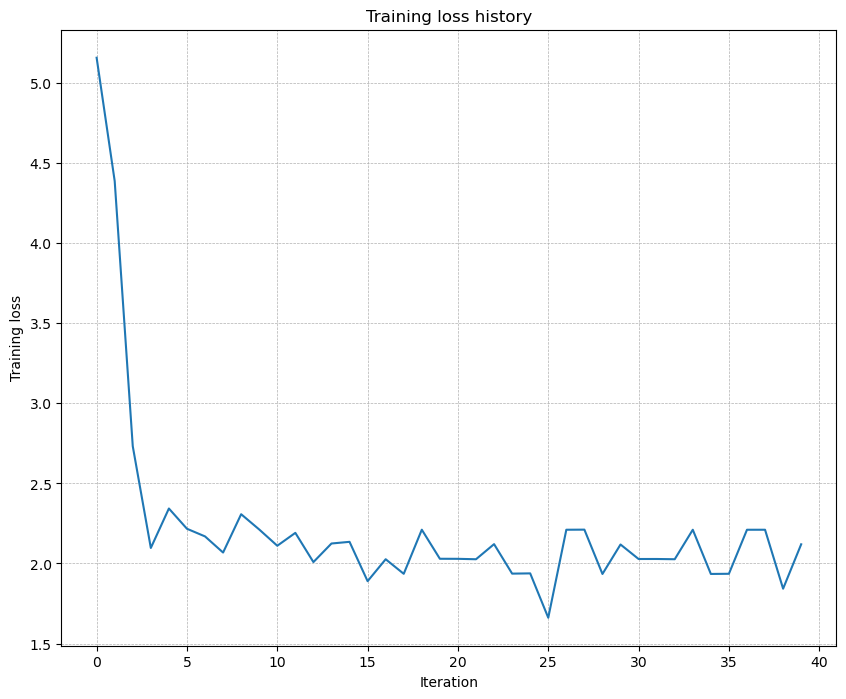

In [20]:
# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  "X_train": data["X_train"][:num_train],
  "y_train": data["y_train"][:num_train],
  "X_val": data["X_val"],
  "y_val": data["y_val"],
}

weight_scale = 3e-2   # Experiment with this!
learning_rate = 4e-3  # Experiment with this!
model = FullyConnectedNet(
    [100, 100],
    weight_scale=weight_scale,
    dtype=np.float64
)
solver = Solver(
    model,
    small_data,
    print_every=10,
    num_epochs=20,
    batch_size=25,
    update_rule="sgd",
    optim_config={"learning_rate": learning_rate},
)
solver.train()

plt.plot(solver.loss_history)
plt.title("Training loss history")
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

Now, try to use a five-layer network with 100 units on each layer to overfit on 50 training examples. Again, you will have to adjust the learning rate and weight initialization scale, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 34.372553
(Epoch 0 / 20) train acc: 0.140000; val_acc: 0.122000
(Epoch 1 / 20) train acc: 0.100000; val_acc: 0.103000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.117000
(Epoch 3 / 20) train acc: 0.140000; val_acc: 0.122000
(Epoch 4 / 20) train acc: 0.240000; val_acc: 0.116000
(Epoch 5 / 20) train acc: 0.220000; val_acc: 0.110000
(Iteration 11 / 40) loss: 1.687842
(Epoch 6 / 20) train acc: 0.220000; val_acc: 0.120000
(Epoch 7 / 20) train acc: 0.220000; val_acc: 0.118000
(Epoch 8 / 20) train acc: 0.220000; val_acc: 0.118000
(Epoch 9 / 20) train acc: 0.220000; val_acc: 0.118000
(Epoch 10 / 20) train acc: 0.220000; val_acc: 0.118000
(Iteration 21 / 40) loss: 1.842358
(Epoch 11 / 20) train acc: 0.220000; val_acc: 0.118000
(Epoch 12 / 20) train acc: 0.220000; val_acc: 0.118000
(Epoch 13 / 20) train acc: 0.220000; val_acc: 0.118000
(Epoch 14 / 20) train acc: 0.220000; val_acc: 0.118000
(Epoch 15 / 20) train acc: 0.220000; val_acc: 0.119000
(Iteration 31 / 40) loss:

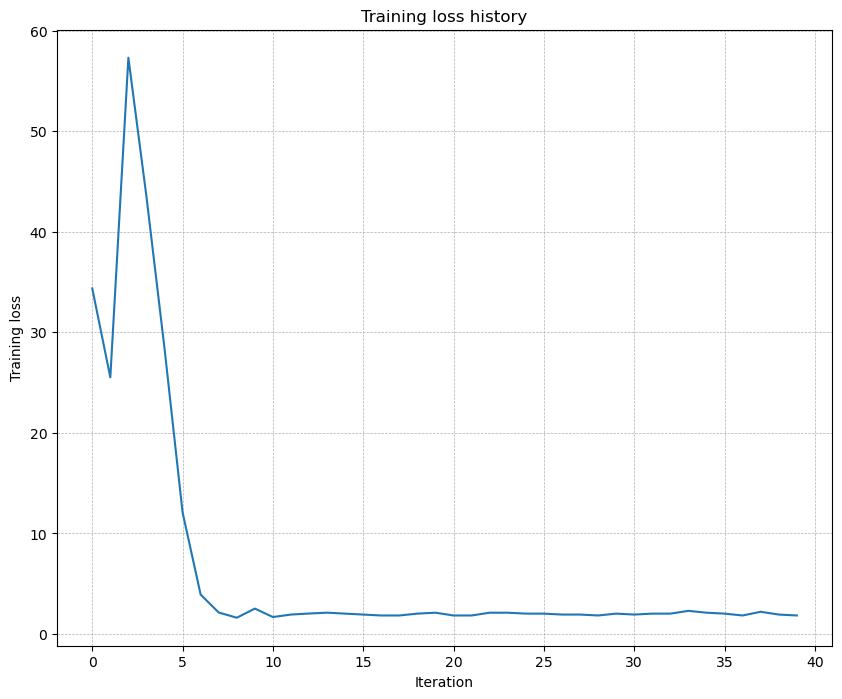

In [40]:
# TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 3e-3  # Experiment with this!
weight_scale = 8e-2   # Experiment with this!
model = FullyConnectedNet(
    [100, 100, 100, 100],
    weight_scale=weight_scale,
    dtype=np.float64
)
solver = Solver(
    model,
    small_data,
    print_every=10,
    num_epochs=20,
    batch_size=25,
    update_rule='sgd',
    optim_config={'learning_rate': learning_rate},
)
solver.train()

plt.plot(solver.loss_history)
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

## Inline Question 1: 
Did you notice anything about the comparative difficulty of training the three-layer network vs. training the five-layer network? In particular, based on your experience, which network seemed more sensitive to the initialization scale? Why do you think that is the case?

## Answer:
training the five-layer network, More fluctuation at start point in loss graph than training the three-layer network and more training loss too. 


In [44]:
from tabulate import tabulate

# Define some learning rates and weight scales
learning_rates = [5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
weight_scales = [.75e-4, 1e-3, *np.linspace(2.5e-3, .01, 4), *np.linspace(2.5e-2, .1, 4), .25, .5]

# List of lists of accuracies for each learning rate and weight scale
accs_3_layer = []
accs_5_layer = []

for ws in weight_scales:
    # Initialize accuracy list with first element denoting the weight scale
    ws_per_lr_1 = [ws]
    ws_per_lr_2 = [ws]

    for lr in learning_rates:
        # Define 3 and 5 layer networks
        model_3_layer = FullyConnectedNet([100]*2, weight_scale=ws, dtype=np.float64)
        model_5_layer = FullyConnectedNet([100]*4, weight_scale=ws, dtype=np.float64)
        
        # Define solver for 3-layer model
        solver_1 = Solver(
            model_3_layer,
            small_data,
            num_epochs=20,
            batch_size=25,
            optim_config={'learning_rate': lr},
            verbose=False
        )

        # Define solver for 5-layer model
        solver_2 = Solver(
            model_5_layer,
            small_data,
            num_epochs=20,
            batch_size=25,
            optim_config={'learning_rate': lr},
            verbose=False
        )

        # Use solvers to train both models
        solver_1.train()
        solver_2.train()

        # An epoch containing the highest traing accuracy
        first_best_1 = np.argmax(solver_1.train_acc_history)
        first_best_2 = np.argmax(solver_2.train_acc_history)

        # Append a tuple of an epoch with the highest accuracy and the rounded accuracy itself
        ws_per_lr_1.append((int(first_best_1), round(solver_1.train_acc_history[first_best_1], 2)))
        ws_per_lr_2.append((int(first_best_2), round(solver_2.train_acc_history[first_best_2], 2)))

        # Consider vanishing gradient if low accuracy didn't change for a while
        if first_best_1 < 14 and ws_per_lr_1[-1][1] < .7:
            ws_per_lr_1[-1] = 'vanished'
        
        if first_best_2 < 14 and ws_per_lr_2[-1][1] < .7:
            ws_per_lr_2[-1] = 'vanished'

        # Consider exploding gradient if NaN value was introduced during gradient update
        if np.isnan(solver_1.loss_history[-1]):
            ws_per_lr_1[-1] = 'exploded'

        if np.isnan(solver_2.loss_history[-1]):
            ws_per_lr_2[-1] = 'exploded'

    # Append the list of accuracies for each learning rate
    accs_3_layer.append(ws_per_lr_1)
    accs_5_layer.append(ws_per_lr_2)

# Print two tables (for 3-layer and 5-layer nets) indicating accuracies for each weight scale
print('\nBest accuracies and the number of epochs taken to reach it')
print('\n##### 3-layer net: (epoch, accuracy) #####\n')
print(tabulate(accs_3_layer, headers=['ws/lr', *learning_rates]))
print('\n##### 5-layer net: (epoch, accuracy) #####\n')
print(tabulate(accs_5_layer, headers=['ws/lr', *learning_rates]))


/home/keonwooro/codespace/cs231n/assignment2_colab/assignment2/cs231n/layers.py:147: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(P[range(N), y])) / N     # sum cross entropies as loss
/home/keonwooro/codespace/cs231n/assignment2_colab/assignment2/cs231n/layers.py:28: RuntimeWarning: overflow encountered in matmul
  out = x.reshape(x.shape[0],-1) @ w + b
/home/keonwooro/codespace/cs231n/assignment2_colab/assignment2/cs231n/layers.py:28: RuntimeWarning: invalid value encountered in matmul
  out = x.reshape(x.shape[0],-1) @ w + b
/home/keonwooro/codespace/cs231n/assignment2_colab/assignment2/cs231n/classifiers/fc_net.py:199: RuntimeWarning: overflow encountered in square
  dout, dW, db, dgamma, dbeta = generic_backward(dout, cache[l])
/home/keonwooro/codespace/cs231n/assignment2_colab/assignment2/cs231n/classifiers/fc_net.py:199: RuntimeWarning: invalid value encountered in scalar multiply
  dout, dW, db, dgamma, dbeta = generic_backward(dout, cache[l])
/home


Best accuracies and the number of epochs taken to reach it

##### 3-layer net: (epoch, accuracy) #####

  ws/lr  5e-06       1e-05       5e-05       0.0001      0.0005      0.001       0.005       0.01
-------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
7.5e-05  vanished    vanished    vanished    vanished    vanished    vanished    vanished    vanished
0.001    vanished    vanished    vanished    vanished    vanished    (17, 0.2)   (14, 0.26)  vanished
0.0025   vanished    vanished    vanished    vanished    vanished    (18, 0.22)  vanished    vanished
0.005    vanished    vanished    vanished    (18, 0.12)  (14, 0.24)  (16, 0.36)  (14, 0.32)  (20, 0.78)
0.0075   vanished    vanished    vanished    (17, 0.22)  (15, 0.4)   (17, 0.48)  (20, 0.78)  (20, 0.88)
0.01     vanished    vanished    (16, 0.2)   (20, 0.24)  (20, 0.28)  (18, 0.6)   (20, 0.66)  (14, 0.64)
0.025    (20, 0.14)  vanished    (17, 0.16)  (19, 0.46)  vanished    vanish

# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

## SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent. See the Momentum Update section at http://cs231n.github.io/neural-networks-3/#sgd for more information.

Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than e-8.

In [43]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {"learning_rate": 1e-3, "velocity": v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print("next_w error: ", rel_error(next_w, expected_next_w))
print("velocity error: ", rel_error(expected_velocity, config["velocity"]))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

Running with  sgd
(Iteration 1 / 200) loss: 2.439737
(Epoch 0 / 5) train acc: 0.093000; val_acc: 0.112000
(Iteration 11 / 200) loss: 2.348417
(Iteration 21 / 200) loss: 2.224755
(Iteration 31 / 200) loss: 2.293978
(Epoch 1 / 5) train acc: 0.189000; val_acc: 0.184000
(Iteration 41 / 200) loss: 2.164608
(Iteration 51 / 200) loss: 2.193400
(Iteration 61 / 200) loss: 2.131139
(Iteration 71 / 200) loss: 2.183134
(Epoch 2 / 5) train acc: 0.230000; val_acc: 0.248000
(Iteration 81 / 200) loss: 2.137383
(Iteration 91 / 200) loss: 2.155290
(Iteration 101 / 200) loss: 2.154963
(Iteration 111 / 200) loss: 2.025929
(Epoch 3 / 5) train acc: 0.254000; val_acc: 0.245000
(Iteration 121 / 200) loss: 2.101265
(Iteration 131 / 200) loss: 2.033605
(Iteration 141 / 200) loss: 1.901431
(Iteration 151 / 200) loss: 2.177684
(Epoch 4 / 5) train acc: 0.304000; val_acc: 0.267000
(Iteration 161 / 200) loss: 2.007715
(Iteration 171 / 200) loss: 2.087331
(Iteration 181 / 200) loss: 2.037486
(Iteration 191 / 200) los

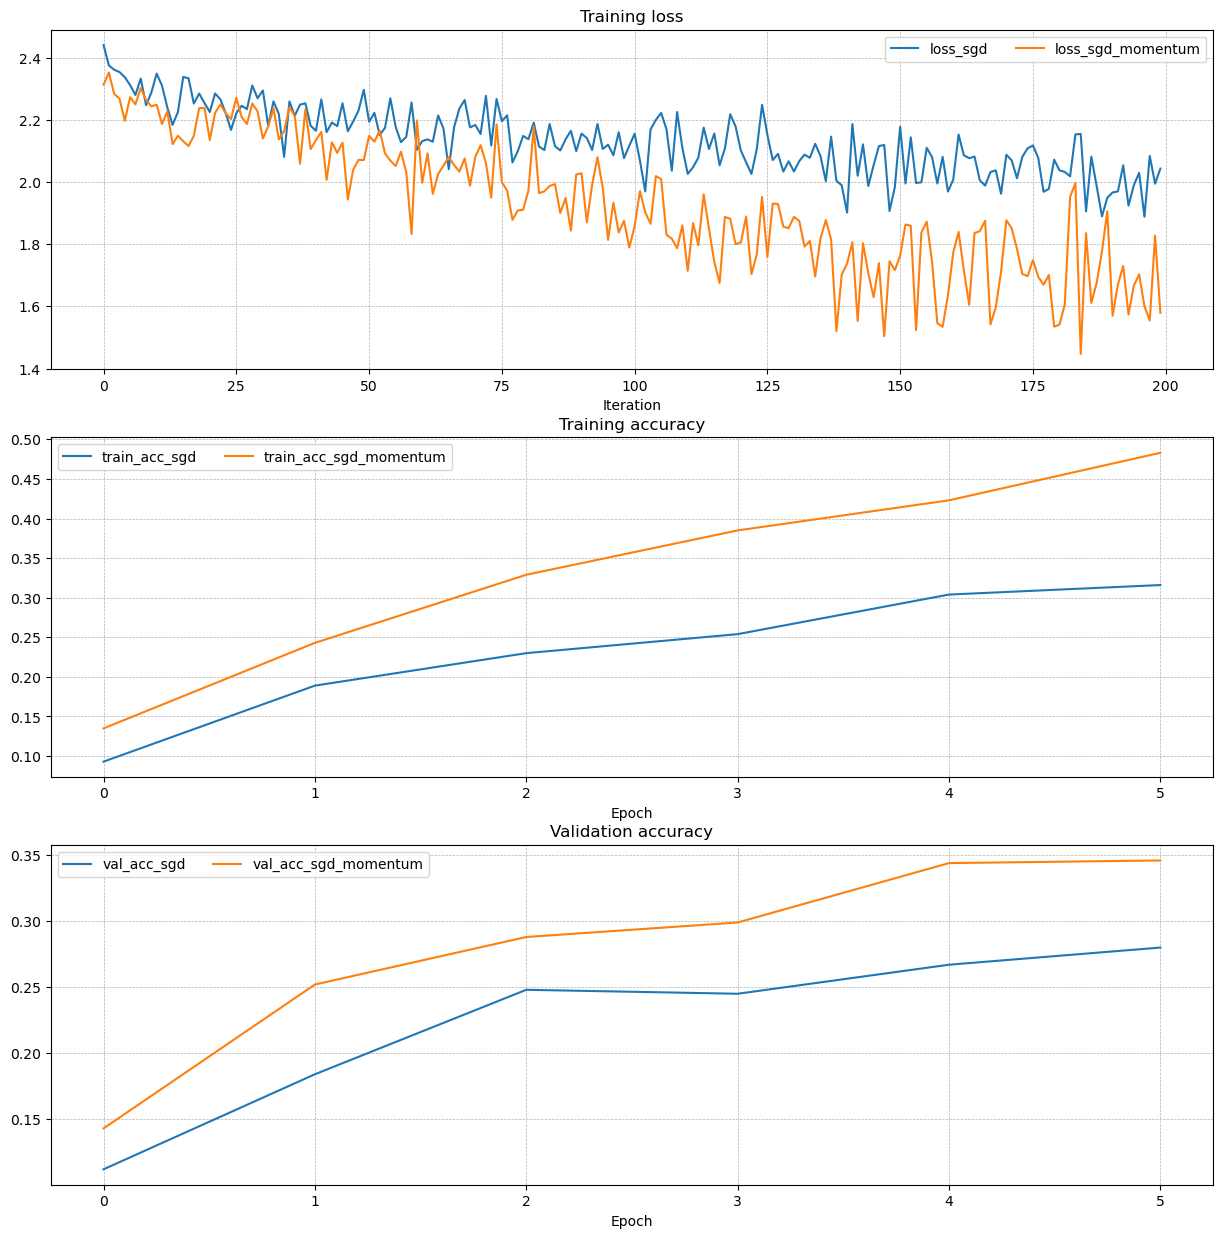

In [45]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print('Running with ', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )

    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={'learning_rate': 5e-3},
        verbose=True,
    )
    solvers[update_rule] = solver
    solver.train()

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"loss_{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"train_acc_{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"val_acc_{update_rule}")
    
for ax in axes:
    ax.legend(loc="best", ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

## RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

**NOTE:** Please implement the _complete_ Adam update rule (with the bias correction mechanism), not the first simplified version mentioned in the course notes. 

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [47]:
# Test RMSProp implementation
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [58]:
# Test Adam implementation
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  0.012622841055840864
v error:  0.4709132700572565
m error:  4.214963193114416e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

Running with  adam
(Iteration 1 / 200) loss: 2.496788
(Epoch 0 / 5) train acc: 0.165000; val_acc: 0.146000
(Iteration 11 / 200) loss: 2.358174
(Iteration 21 / 200) loss: 2.188870
(Iteration 31 / 200) loss: 2.260375
(Epoch 1 / 5) train acc: 0.301000; val_acc: 0.251000
(Iteration 41 / 200) loss: 2.185435
(Iteration 51 / 200) loss: 1.840197
(Iteration 61 / 200) loss: 2.046334
(Iteration 71 / 200) loss: 1.825519
(Epoch 2 / 5) train acc: 0.377000; val_acc: 0.320000
(Iteration 81 / 200) loss: 1.962081
(Iteration 91 / 200) loss: 1.959213
(Iteration 101 / 200) loss: 1.913317
(Iteration 111 / 200) loss: 1.902161
(Epoch 3 / 5) train acc: 0.404000; val_acc: 0.305000
(Iteration 121 / 200) loss: 1.769086
(Iteration 131 / 200) loss: 1.617550
(Iteration 141 / 200) loss: 1.672119
(Iteration 151 / 200) loss: 1.680701
(Epoch 4 / 5) train acc: 0.503000; val_acc: 0.322000
(Iteration 161 / 200) loss: 1.658612
(Iteration 171 / 200) loss: 1.460103
(Iteration 181 / 200) loss: 1.448523
(Iteration 191 / 200) lo

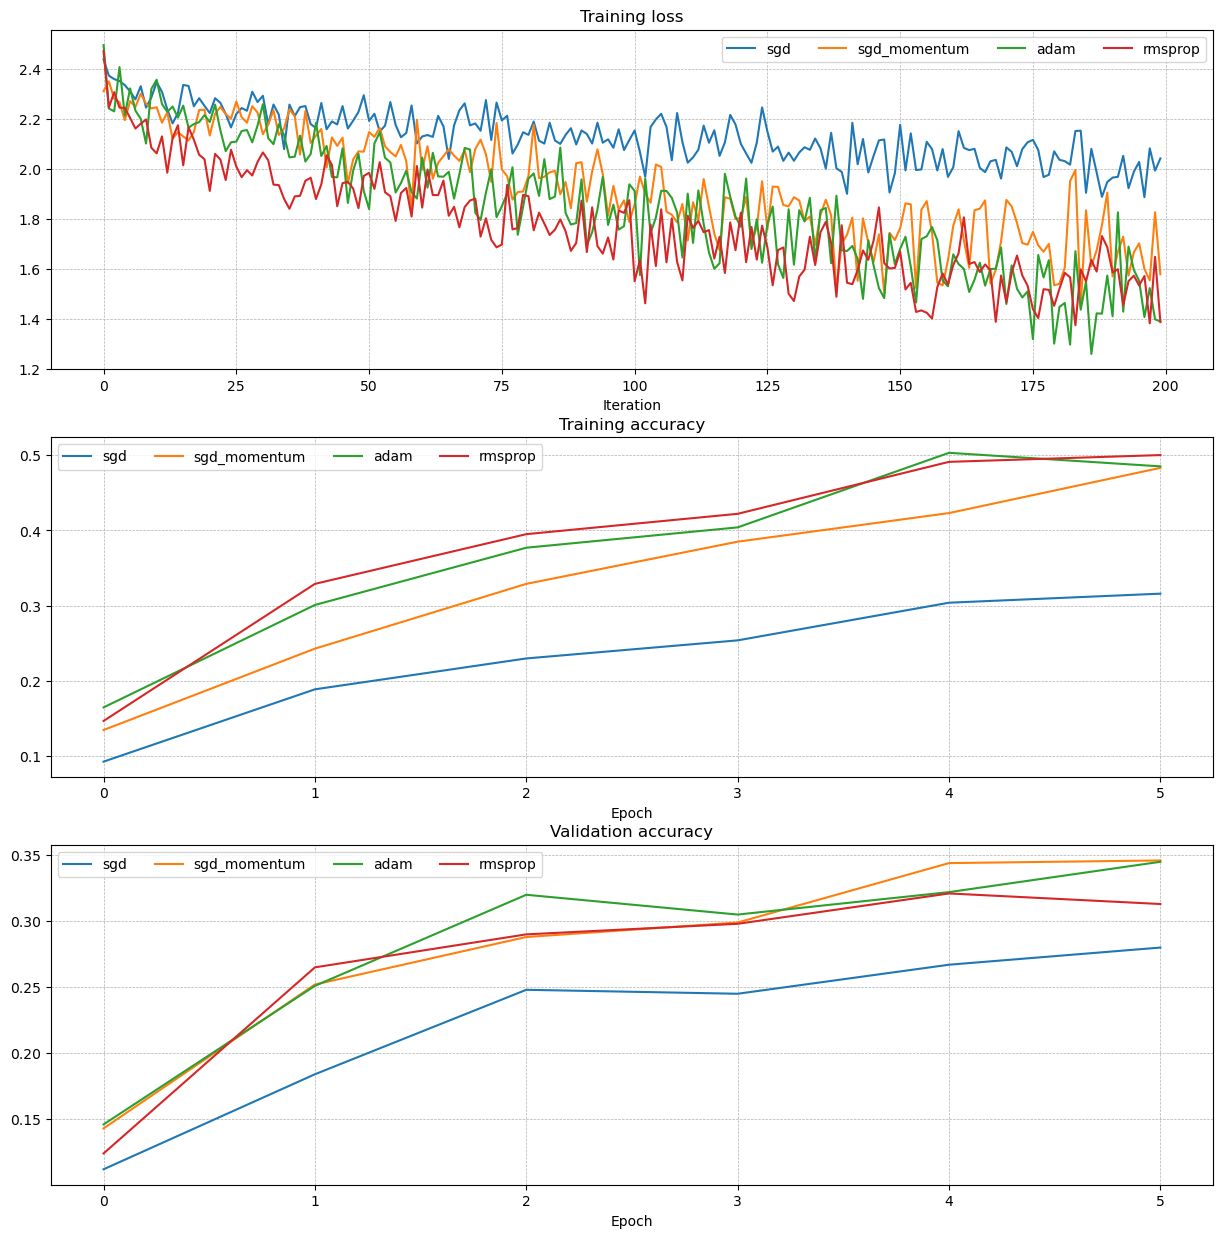

In [90]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
    print('Running with ', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )
    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={'learning_rate': learning_rates[update_rule]},
        verbose=True
    )
    solvers[update_rule] = solver
    solver.train()
    print()
    
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"{update_rule}")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

## Inline Question 2:

AdaGrad, like Adam, is a per-parameter optimization method that uses the following update rule:

```
cache += dw**2
w += - learning_rate * dw / (np.sqrt(cache) + eps)
```

John notices that when he was training a network with AdaGrad that the updates became very small, and that his network was learning slowly. Using your knowledge of the AdaGrad update rule, why do you think the updates would become very small? Would Adam have the same issue?


## Answer: 
Because denominator is accumulated with dw**2. Adam does not have this problem since it decay the accumlated squared gradients.


# Train a Good Model!
Train the best fully connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully connected network.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional networks rather than fully connected networks.

**Note:** You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [95]:
best_model = None

################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

best_val = -1    # keep track of best validation accuracy
best_params = {} # dict to hold best model parameters
num_train = 500  # amount of training data for tests

# Generate small dataset
small_data = {
  "X_train": data["X_train"][:num_train],
  "y_train": data["y_train"][:num_train],
  "X_val": data["X_val"],
  "y_val": data["y_val"],
}

for i in range(30):
    lr = 10 ** np.random.uniform(-5, -3)   # learning rate
    ws = 10 ** np.random.uniform(-2, -1.5) # weight scale
    reg = 10 ** np.random.uniform(-3, 0)   # reguarization
    kr = np.random.uniform(.7, .9)         # dropout keep ratio

    model = FullyConnectedNet([256,128,100],
                              weight_scale=ws,
                              reg=reg,
                              dropout_keep_ratio=kr,
                              normalization='batchnorm',
                              )
    
    sovler = Solver(model, small_data,
                    num_epochs=20,
                    batch_size=256,
                    update_rule='adam',
                    optim_config={learning_rate:lr},
                    verbose=False)
    
    solver.train()
    new_val = solver.best_val_acc

    if new_val > best_val:
        best_val = new_val
        best_params = {'lr':lr, 'ws':ws, 'reg':reg, 'kr':kr}
    
    print(f'lr: {lr:.5f} ws: {ws:.5f}, reg: {reg:.5f}, kr: {kr:.5f}, acc: {new_val:.5f}')

# Print the best accuracy using small data
print(f'Best validation accuracy using a small dataset: {best_val}')
print(f'\nTraining with best parameters...')

# Create the best model with the best parameters
best_model = FullyConnectedNet([256,128,100],
                               weight_scale=best_params['ws'],
                               reg=best_params['reg'],
                               dropout_keep_ratio=best_params['kr'],
                               normalization='batchnorm')

# Create solver to train the model on full dataset
solver = Solver(best_model, data,
                num_epochs=15, batch_size=256,
                update_rule='adam',
                optim_config={'learning_rate': best_params['lr']},
                verbose=False)

solver.train() # train the best model

# Print the final validation accuracy acquired with the best model
print(f'Best validation accuracy using full dataset: {solver.best_val_acc}')

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

lr: 0.00002 ws: 0.01279, reg: 0.00186, kr: 0.72025, acc: 0.42900
lr: 0.00002 ws: 0.01034, reg: 0.00150, kr: 0.81048, acc: 0.43800
lr: 0.00053 ws: 0.01032, reg: 0.21724, kr: 0.75109, acc: 0.43800
lr: 0.00004 ws: 0.01711, reg: 0.02132, kr: 0.78562, acc: 0.43800
lr: 0.00072 ws: 0.01542, reg: 0.16731, kr: 0.78687, acc: 0.43800
lr: 0.00002 ws: 0.01338, reg: 0.21931, kr: 0.82451, acc: 0.45100
lr: 0.00072 ws: 0.02711, reg: 0.04835, kr: 0.76754, acc: 0.45100
lr: 0.00044 ws: 0.01154, reg: 0.42502, kr: 0.75186, acc: 0.45100
lr: 0.00011 ws: 0.01192, reg: 0.24730, kr: 0.81021, acc: 0.45100
lr: 0.00010 ws: 0.01265, reg: 0.01143, kr: 0.75180, acc: 0.45100
lr: 0.00082 ws: 0.01148, reg: 0.00244, kr: 0.87204, acc: 0.45100
lr: 0.00011 ws: 0.01746, reg: 0.01105, kr: 0.79354, acc: 0.45100
lr: 0.00003 ws: 0.01794, reg: 0.41332, kr: 0.88202, acc: 0.45100
lr: 0.00003 ws: 0.01840, reg: 0.03706, kr: 0.85074, acc: 0.45100
lr: 0.00047 ws: 0.02315, reg: 0.43716, kr: 0.89837, acc: 0.45100
lr: 0.00018 ws: 0.02137, 

# Test Your Model!
Run your best model on the validation and test sets. You should achieve at least 50% accuracy on the validation set.

In [96]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.425
Test set accuracy:  0.394
